# Exercise: Parallel Monte Carlo

**Note: You should use 4 workers for this exercise.**

In [1]:
using Distributed
addprocs(4)
@assert nworkers() == 4

Calculate the value of $\pi$ through parallel direct Monte Carlo.

A unit circle is inscribed inside a unit square with side length 2 (from -1 to 1). The area of the circle is $\pi$, the area of the square is 4, and the ratio is $\pi/4$. This means that, if you throw $N$ darts randomly at the square, approximately $M=N\pi/4$ of those darts will land inside the unit circle.

Throw darts randomly at a unit square and count how many of them ($M$) landed inside of a unit circle. Approximate $\pi \approx 4M/N$. Visualization:

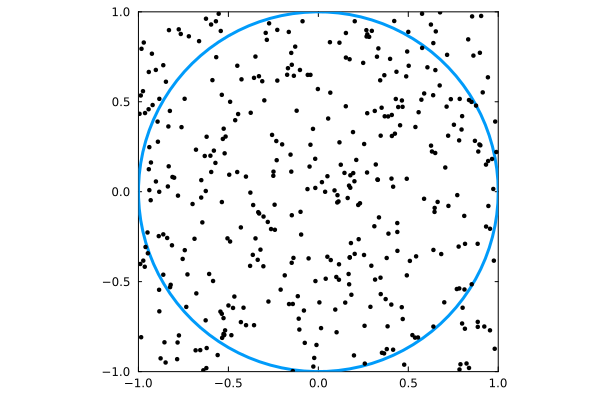

In [2]:
ENV["GKS_ENCODING"]="utf-8"
using Plots, Distributions

# plot circle
circlepts = Plots.partialcircle(0, 2π, 100)
plot(circlepts, aspect_ratio=:equal, xlims=(-1,1), ylims=(-1,1), legend=false, lw=3, grid=false, frame=:box)

# plot darts
N = 400
d = Uniform(-1, 1)
scatter!(rand(d, N), rand(d, N), ms=2.5, color=:black)

### Basic Julia Implementation

In [3]:
@everywhere function compute_pi(N)
    M = 0 # number of darts that landed in the circle
    for i in 1:N
        if sqrt(rand()^2 + rand()^2) < 1.0
            M += 1
        end
    end
    return 4 * M / N
end

In [4]:
compute_pi(10_000_000)

3.140774

### Tasks

1. Based on `compute_pi`, write a parallel version `compute_pi_parallel(N::Int)` that (equally) divides the work among the 8 worker processes. The final estimate for π should be the average of the estimate of each worker.
    1. **Hint:** Use `@distributed (reducer) ...`

2. Benchmark and compare the serial and parallel variants.
    1. **Hint:** A reasonable value is `N = 10_000_000`.

In [8]:
function compute_pi_parallel(N)
    Msum = @distributed (+) for i in 1:N
        local M = zero(Int)
        if sqrt(rand()^2 + rand()^2) < 1.0
            M += 1
        end
        M
    end
    return 4 * Msum / N
end

compute_pi_parallel (generic function with 1 method)

In [9]:
using BenchmarkTools

@btime compute_pi(10_000_000) samples=10 evals=5
@btime compute_pi_parallel(10_000_000) samples=10 evals=5

  51.438 ms (0 allocations: 0 bytes)
  13.699 ms (303 allocations: 12.97 KiB)


3.1423772

3. Write a function `compute_pi_multiple(Ns::Vector{Int})` which takes in a collection of values for $N$ (`Ns`) and **in serial** computes $\pi$ for all these values. The function should be entirely serial and based on `compute_pi`. Benchmark and compare to the previous variants.

In [ ]:
some_Ns = [1_000_000, 2_000_000, 3_000_000, 4_000_000]

function compute_pi_multiple(Ns::Vector{Int})
    # TODO...
end

In [ ]:
# @btime compute_pi_multiple(some_Ns) samples=5 evals=2

4. Write a function `compute_pi_multiple_parallel(Ns::Vector{Int})` which takes in a collection of values for $N$ (`Ns`) and **in parallel** computes $\pi$ for all these values. The function should still be based on the serial `compute_pi`. Benchmark and compare to the previous variants.
    1. **Hint:** `pmap`. Why?

In [13]:
some_Ns = [1_000_000, 2_000_000, 3_000_000, 4_000_000]

function compute_pi_multiple_parallel(Ns::Vector{Int})
    pmap(Ns) do N
        compute_pi(N)
    end  
end

compute_pi_multiple_parallel (generic function with 1 method)

In [14]:
@btime compute_pi_multiple_parallel($some_Ns) samples=5 evals=2

  20.842 ms (279 allocations: 12.44 KiB)


4-element Vector{Float64}:
 3.141192
 3.139878
 3.1432906666666667
 3.140634

5. Calculate $\pi$ estimates for the following $N$ values: `Ns = ceil.(Int, exp10.(range(1, stop=8, length=50)))`. Plot $\pi$ vs $N$ on a semi-log plot.

In [12]:
# N values (nothing todo here)
Ns = ceil.(Int, exp10.(range(1, stop=8, length=50)));

In [17]:
# Important: the resulting pi estimates should be stored in a variable named: pis
function compute_pi_multiple_parallel(Ns::Vector{Int})
    pis = pmap(Ns) do N
        compute_pi(N)
    end  
    return pis
end

compute_pi_multiple_parallel (generic function with 1 method)

In [18]:
pis = compute_pi_multiple_parallel(Ns)

50-element Vector{Float64}:
 2.4
 2.0
 3.4
 3.259259259259259
 3.0526315789473686
 2.8461538461538463
 2.9444444444444446
 3.12
 2.964028776978417
 3.051546391752577
 ⋮
 3.140236355953717
 3.142256
 3.141284012794572
 3.1409615735823597
 3.1412166821150573
 3.1419110097242893
 3.1412095130033166
 3.1412922930465976
 3.14176016

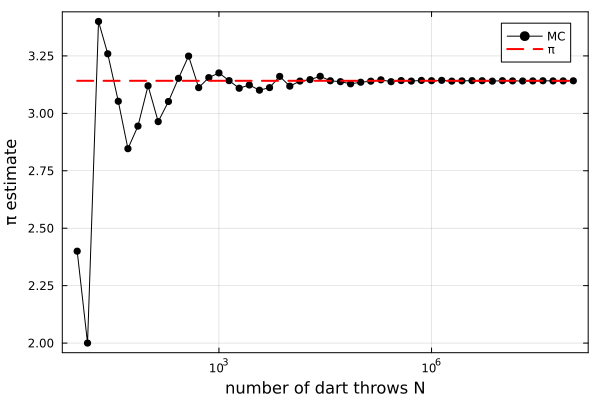

In [19]:
# Plotting (nothing todo here)
plot(Ns, pis, color=:black, marker=:circle, lw=1, label="MC", xscale=:log10, frame=:box)
plot!(x -> π, label="π", xscale=:log10, linestyle=:dash, color=:red, lw=2)
ylabel!("π estimate")
xlabel!("number of dart throws N")